## Area-perimeter self-propelled Voronoi model

After the toy example of notebook 02, let's try to implement a slightly more complicated model, the self-propelled Voronoi area-perimeter Voronoi (VAP) model of [Bi et al., 2016](https://journals.aps.org/prx/abstract/10.1103/PhysRevX.6.021011). This 2D model comprises most of the ingredients we will see in more general simulations, from a coding perspective.

In brief, in the VAP, cells are modeled as the Voronoi tesselation for a series of centroids $\mathbf{v}_i$ (our triangulation vertices). Their overdamped dynamics comprises two terms: self-propulsion and relaxation of an elastic energy:
$$\partial_t \mathbf{v}_i = -\nabla_{\mathbf{v}_i} E_{AP} + v_0 \hat{\mathbf{n}}_i$$
For each cell $i$, $\hat{\mathbf{n}}_i$ is a unit vector (so we will represent it by an angle $\theta_i$) that determines the direction of motion. Units of time are chosen so that the coefficient of $\nabla E_{AP}$ is $1$.
The energy is defined in terms of the Voronoi area $a_i$ and Voronoi perimeter $p_i$ of each cell:
$$E_{AP} = \sum_i k_a(a_i-a_0)^2 + k_p(p_i-p_0)^2 $$
where $k_a, k_p$ are elastic constants, and $a_0, p_0$ are the target area and perimeter. They define the "shape index" $s_0= p_0/\sqrt{a_0}$. The key physics is that above a critical shape index $s_0^*$, the model has a degenerate set of ground states, since for a large $p_0$, there are many polygons with the given target area and perimeter (think floppy balloon).

The orientation $\theta_i$ of each cell is also dynamic. It undergoes rotational diffusion:
$$d\theta_i = D_\theta dW_{t, i} $$
where $dW_{t,i}$ is Brownian motion, independent for each cell $i$, and $D_\theta$ is the diffusion constant.

#### Numerics

The cell array connectivity will be represented by a `HeMesh` (see notebook 01). The geometry is fully described by the triangulation vertex positions, the Voronoi cell centroids. We also need a scalar vertex attribute for the angle $\theta_i$.

To numerically calculate the energy $E_{AP}$, we can obtain Voronoi area and perimeter for each mesh "corner" using the  `triangulax.trigonometry` module. Then we can use the gather/scatter operation `triangulax.meshsum_he_to_vertex_opposite` to sum all corners belonging to a cell (see notebook 01, "Computing cell areas, perimeters, etc via corners"). 
Boundary cells can be handled by "mirroring", i.e., all corners count twice when computing the area/perimeter. Given the energy, JAX autodiff gives us the gradients.

To time-evolve the mesh geometry, we can use `diffrax`, like in notebook 02. `diffrax` can also deal with SDEs, like the Langevin equation for cell angles.
After each timestep, we need to check if the Voronoi edge lengths are below some threshold (the edge lengths can be computed on the fly), and, if so, we need to carry out edge flips. See notebook 01. 
We need to ensure that we do not immidiately "re-flip" an edge. This could be done, for example, via "cool down" period (an edge flipped at step $t$ cannot be flipped again for the next few steps), or by calculating if the edge is shrinking or growing.

It would also be great to generate some visualizations of the time evolution of the mesh using the `cellplot` function, maybe with a user-controlled slider to show the different time steps.

The code should respect the coding style (JAX-compatibility, type hints, etc) used in previous notebooks. To start, let's define the energy and check that relaxation of the energy leads to a state where the $a_i=a_0$ and $p_i=p_0$ constraints are fullfilled (as good as possible).



### Setup


In [1]:
import copy
import dataclasses
from typing import Tuple

import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
from jaxtyping import Float, Bool, Int
import diffrax

from tqdm.notebook import tqdm

In [2]:
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_debug_nans", False)
jax.config.update("jax_log_compiles", False)

In [3]:
from triangulax import mesh as msh
from triangulax.mesh import TriMesh, HeMesh, GeomMesh
from triangulax import trigonometry as trig

In [4]:
from importlib import reload

In [23]:
reload(msh); reload(trig)

<module 'triangulax.trigonometry' from '/Users/nc1333/Documents/Princeton/Coding/triangulax/triangulax/trigonometry.py'>

### Read in test data

In [4]:
mesh = TriMesh.read_obj("test_meshes/disk.obj")
hemesh = HeMesh.from_triangles(mesh.vertices.shape[0], mesh.faces)
geommesh = GeomMesh(*hemesh.n_items, vertices=mesh.vertices)
geommesh = msh.set_voronoi_face_positions(geommesh, hemesh)

hemesh, geommesh

  o flat_tri_ecmc


(HeMesh(N_V=131, N_HE=708, N_F=224), GeomMesh(D=2,N_V=131, N_HE=708, N_F=224))

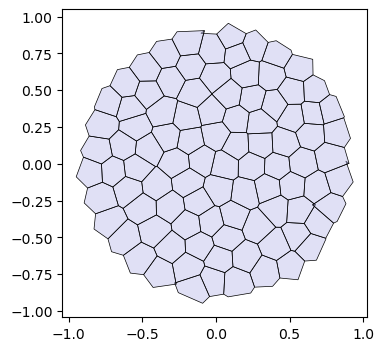

In [5]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.add_collection(msh.cellplot(hemesh, geommesh.face_positions,
                               cell_colors=np.array([0.7, 0.7, 0.9, 0.4]),
                               mpl_polygon_kwargs={"lw": 0.5, "ec": "k"}))
ax.set_aspect("equal")
ax.autoscale_view();

## Voronoi cell geometry (area & perimeter)
We compute areas from corner contributions and perimeters from dual-edge lengths, using gather/scatter operations on the half-edge mesh. Boundary cells are handled by mirroring (doubling the area/perimeter).

In [79]:
@jax.jit
def get_cell_area(geommesh: GeomMesh, hemesh: HeMesh) ->Float[jax.Array, " n_vertices"]:
    """Compute Voronoi area for each cell."""
    a = hemesh.dest[hemesh.nxt]
    b = hemesh.dest[hemesh.prv]
    c = hemesh.dest
    corner_areas = jax.vmap(trig.get_voronoi_corner_area)(
        geommesh.vertices[a], geommesh.vertices[b], geommesh.vertices[c])
    cell_areas = msh.sum_he_to_vertex_opposite(hemesh, corner_areas)
    cell_areas = jnp.where(hemesh.is_bdry, 2.0 * cell_areas, cell_areas)
    return cell_areas

def get_cell_perimeter(geommesh: GeomMesh, hemesh: HeMesh) -> Float[jax.Array, " n_vertices"]:
    """Compute Voronoi perimeters for each cell."""
    a = hemesh.dest[hemesh.nxt]
    b = hemesh.dest[hemesh.prv]
    c = hemesh.dest
    corner_perims = jax.vmap(trig.get_voronoi_corner_perimeter)(
        geommesh.vertices[a], geommesh.vertices[b], geommesh.vertices[c])
    corner_perims = jnp.clip(corner_perims, 0)
    cell_perims = msh.sum_he_to_vertex_opposite(hemesh, corner_perims)
    cell_perims = jnp.where(hemesh.is_bdry, 2.0 * cell_perims, cell_perims)
    return cell_perims

@jax.jit
def energy_ap(geommesh: GeomMesh, hemesh: HeMesh, a0: float, p0: float,
              k_a: float = 1.0, k_p: float = 1.0) -> Float[jax.Array, ""]:
    """Area-perimeter energy for Voronoi cells."""
    cell_areas = get_cell_area(geommesh, hemesh)    
    cell_perimeters = get_cell_perimeter(geommesh, hemesh)
    return jnp.mean(k_a * (cell_areas - a0) ** 2 + k_p * (cell_perimeters - p0) ** 2)

In [81]:
cell_areas, cell_perimeters = (get_cell_area(geommesh, hemesh), get_cell_perimeter(geommesh, hemesh))

a_mean, p_mean = (cell_areas[~hemesh.is_bdry].mean(), cell_perimeters[~hemesh.is_bdry].mean())
a_mean, p_mean, p_mean/np.sqrt(a_mean)

(Array(0.02756258, dtype=float64),
 Array(0.63463959, dtype=float64),
 Array(3.82267399, dtype=float64))

In [72]:
# double check against "manual" area and "perimeter" computation using mesh traversal

## Energy relaxation (no self-propulsion)
We first relax the area–perimeter energy to verify that the constraints are satisfied.

In [82]:
@jax.jit
def relax_energy_step(geommesh: GeomMesh, hemesh: HeMesh,
              a0: float, p0: float,
              step_size: float = 0.01,
              k_a: float = 1.0, k_p: float = 1.0) -> Tuple[GeomMesh, Float[jax.Array, ""]]:
    loss, grad = jax.value_and_grad(energy_ap)(geommesh, hemesh, a0, p0, k_a, k_p)
    updated_vertices = geommesh.vertices - step_size * grad.vertices
    geommesh_updated = dataclasses.replace(geommesh, vertices=updated_vertices)
    return geommesh_updated, loss


# energy parameters
a0 = a_mean
s0 = 3.5
p0 = s0*jnp.sqrt(a0)

# relaxation parameters
step_size = 0.02
n_steps = 10000

geommesh_relaxed = copy.copy(geommesh)
losses = []

for _ in range(n_steps):
    geommesh_relaxed, loss = relax_energy_step(geommesh_relaxed, hemesh, a0, p0, step_size=step_size)
    losses.append(loss)

losses = jnp.array(losses)

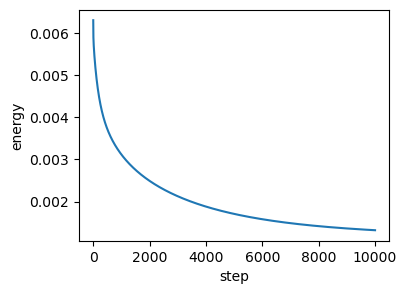

In [83]:
fig = plt.figure(figsize=(4, 3))
plt.plot(np.asarray(losses))
plt.xlabel("step")
plt.ylabel("energy");

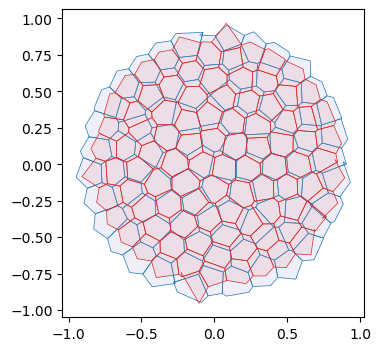

In [84]:
geommesh_relaxed = msh.set_voronoi_face_positions(geommesh_relaxed, hemesh)

fig, ax = plt.subplots(figsize=(4, 4))
ax.add_collection(msh.cellplot(hemesh, geommesh.face_positions,
                               cell_colors=np.array([0.7, 0.7, 0.9, 0.2]),
                               mpl_polygon_kwargs={"lw": 0.5, "ec": "tab:blue"}))
ax.add_collection(msh.cellplot(hemesh, geommesh_relaxed.face_positions,
                               cell_colors=np.array([0.9, 0.6, 0.6, 0.2]),
                               mpl_polygon_kwargs={"lw": 0.5, "ec": "tab:red"}))
ax.set_aspect("equal")
ax.autoscale_view();

In [86]:
areas_relaxed, perim_relaxed = (get_cell_area(geommesh, hemesh), get_cell_perimeter(geommesh, hemesh))
jnp.abs(areas_relaxed - a0)[hemesh.is_bdry].mean(), jnp.abs(perim_relaxed - p0)[hemesh.is_bdry].mean()

(Array(0.09000695, dtype=float64), Array(0.04928358, dtype=float64))

### Relaxation with T1s

Next, let's allow T1s. To ensure we don't flip the same edge multiple times, let's use a cooldown period.

In [87]:
cooldown_steps = 5
l_min_T1 = -0.01

n_steps = 10000
cooldown_counter = jnp.zeros(hemesh.n_hes)
sim_steps = jnp.arange(n_steps)

In [88]:
# package simulation time step into a function for jax.lax.scan
@jax.jit
def scan_fun(carry: Tuple[GeomMesh,HeMesh, Int[jax.Array, " n_steps"]], x: Float[jax.Array, " n_steps"]):
    geommesh_relaxed, hemesh_relaxed, cooldown_counter = carry
    # step energy
    geommesh_relaxed, loss = relax_energy_step(geommesh_relaxed, hemesh_relaxed, a0, p0, step_size=step_size)
    # compute signed edge lengths, flip, and update cooldown counter
    face_positions = msh.get_voronoi_face_positions(geommesh_relaxed.vertices, hemesh_relaxed)
    edge_lengths = msh.get_signed_dual_he_length(geommesh_relaxed.vertices, face_positions, hemesh_relaxed)
    to_flip = (edge_lengths < l_min_T1) & (cooldown_counter == 0)
    hemesh_relaxed = msh.flip_all(hemesh_relaxed, to_flip)
    # update cooldown counter
    cooldown_counter = jnp.where(to_flip, cooldown_steps, jnp.clip(cooldown_counter-1, 0))
    return (geommesh_relaxed, hemesh_relaxed, cooldown_counter), jnp.array([loss, to_flip.sum()])

(geommesh_relaxed, hemesh_relaxed, _), return_arr = jax.lax.scan(scan_fun, (geommesh, hemesh, cooldown_counter), sim_steps) 

losses, flip_count = return_arr.T

(0.0, 77.0)

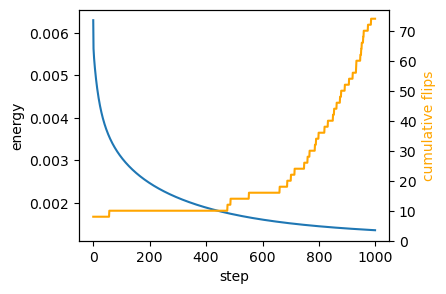

In [93]:
fig = plt.figure(figsize=(4, 3))
plt.plot(losses[::int(n_steps/1000)])
plt.xlabel("step")
plt.ylabel("energy")

# add a twin y axis that shows the cummulative number of flips
ax2 = plt.gca().twinx()
ax2.plot(jnp.cumsum(flip_count)[::int(n_steps/1000)], color="orange")
ax2.set_ylabel("cumulative flips", color="orange")
ax2.set_ylim([0,flip_count.sum()+1])

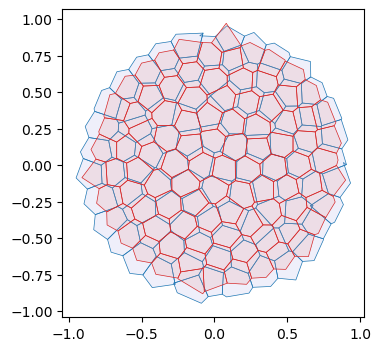

In [90]:
geommesh_relaxed = msh.set_voronoi_face_positions(geommesh_relaxed, hemesh_relaxed)

fig, ax = plt.subplots(figsize=(4, 4))
ax.add_collection(msh.cellplot(hemesh, geommesh.face_positions,
                               cell_colors=np.array([0.7, 0.7, 0.9, 0.2]),
                               mpl_polygon_kwargs={"lw": 0.5, "ec": "tab:blue"}))
ax.add_collection(msh.cellplot(hemesh_relaxed, geommesh_relaxed.face_positions,
                               cell_colors=np.array([0.9, 0.6, 0.6, 0.2]),
                               mpl_polygon_kwargs={"lw": 0.5, "ec": "tab:red"}))
ax.set_aspect("equal")
ax.autoscale_view();

In [91]:
areas_relaxed, perim_relaxed = (get_cell_area(geommesh, hemesh), get_cell_perimeter(geommesh, hemesh))
jnp.abs(areas_relaxed - a0)[~hemesh.is_bdry].mean()/a0, jnp.abs(perim_relaxed - p0)[~hemesh.is_bdry].mean()/p0

(Array(0.09045905, dtype=float64), Array(0.09506297, dtype=float64))

[AI generated content below]

## Overdamped dynamics with self-propulsion (deterministic)
We integrate $\partial_t \mathbf{v}_i = -\nabla_{\mathbf{v}_i} E_{AP} + v_0\hat{\mathbf{n}}_i$ with fixed orientations.

In [ ]:
@jax.tree_util.register_dataclass
@dataclasses.dataclass
class VAPState:
    """State for VAP dynamics."""
    geommesh: GeomMesh
    theta: Float[jax.Array, " n_vertices"]


@jax.jit
def vap_vector_field(t: float, state: VAPState, args: Tuple) -> VAPState:
    hemesh, a0, p0, v0, k_a, k_p = args
    grad_geom = jax.grad(energy_ap)(state.geommesh, hemesh, a0, p0, k_a, k_p)
    n_hat = jnp.stack([jnp.cos(state.theta), jnp.sin(state.theta)], axis=-1)
    velocity = -grad_geom.vertices + v0 * n_hat
    dgeom = dataclasses.replace(
        state.geommesh,
        vertices=velocity,
        face_positions=jnp.zeros_like(state.geommesh.face_positions),
    )
    dtheta = jnp.zeros_like(state.theta)
    return VAPState(geommesh=dgeom, theta=dtheta)

In [33]:
key = jax.random.key(0)
theta0 = jax.random.uniform(key, shape=(hemesh.n_vertices,), minval=0.0, maxval=2 * np.pi)

state0 = VAPState(geommesh=geommesh_relaxed, theta=theta0)
args = (hemesh, a0, p0, 0.02, 1.0, 1.0)

term = diffrax.ODETerm(vap_vector_field)
solver = diffrax.Tsit5()

dt = 0.05
t0 = 0.0
t1 = 1.0
step_times = jnp.arange(t0, t1 + dt, dt)

state = state0
solver_state = solver.init(term, t0, t0 + dt, state0, args)

def scan_fun(carry, t):
    solver_state, state, tprev = carry
    state, _, _, solver_state, _ = solver.step(term, tprev, t, state, args, solver_state, made_jump=False)
    return (solver_state, state, t), state

init = (solver_state, state0, t0)
(_, state_final, _), traj = jax.lax.scan(scan_fun, init, step_times[1:])

state_final

VAPState(geommesh=GeomMesh(D=2,N_V=131, N_HE=708, N_F=224), theta=Array([2.62924358, 1.35902442, 6.06529362, 3.60969331, 3.34407765,
       2.22993501, 5.54810903, 3.97449415, 3.3539648 , 1.20419685,
       5.36695019, 0.37346808, 4.04254935, 6.24593336, 3.78256938,
       2.43986234, 1.86427401, 4.04350545, 2.65350913, 5.86673077,
       3.28952069, 3.49530224, 3.61134731, 3.25868309, 0.49483695,
       2.65597033, 5.44847081, 0.0815077 , 1.80236259, 3.88571405,
       0.78212587, 3.1742906 , 5.65305943, 0.03552294, 1.03057226,
       0.49984771, 0.75858611, 5.28357365, 2.11062344, 4.08461608,
       1.90394486, 3.08182229, 4.11747439, 0.32242419, 2.87977266,
       1.64838549, 3.99764578, 3.02082432, 3.96065204, 0.80522438,
       0.14948794, 4.84820085, 1.01252678, 3.03934314, 6.23419932,
       1.30784405, 0.92344992, 0.65224909, 1.43848565, 1.87620624,
       3.94727408, 3.32947945, 6.09053058, 4.85059338, 0.60390009,
       3.62798414, 5.91464415, 6.20134698, 0.90452161, 5.372276

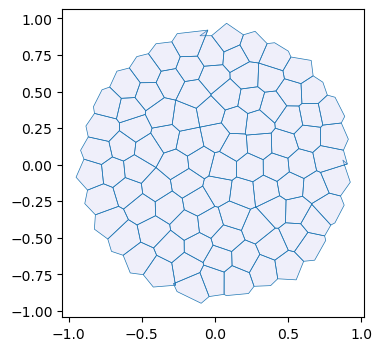

In [34]:
geommesh_final = msh.set_voronoi_face_positions(state_final.geommesh, hemesh)

fig, ax = plt.subplots(figsize=(4, 4))
ax.add_collection(msh.cellplot(hemesh, geommesh_relaxed.face_positions,
                               cell_colors=np.array([0.7, 0.7, 0.9, 0.2]),
                               mpl_polygon_kwargs={"lw": 0.5, "ec": "tab:blue"}))
ax.add_collection(msh.cellplot(hemesh, geommesh_final.face_positions,
                               cell_colors=np.array([0.9, 0.6, 0.6, 0.2]),
                               mpl_polygon_kwargs={"lw": 0.5, "ec": "tab:red"}))
ax.set_aspect("equal")
ax.autoscale_view();

### Stochastic orientation + T1 flips (step-by-step)
We now include rotational diffusion for $\theta_i$ and perform edge flips when Voronoi dual edges fall below a threshold. A short cooldown avoids immediate re-flips.

In [ ]:
@jax.jit
def compute_velocity(geommesh: GeomMesh, hemesh: HeMesh, theta: Float[jax.Array, " n_vertices"],
                     a0: float, p0: float, v0: float, k_a: float = 1.0, k_p: float = 1.0
                     ) -> Float[jax.Array, "n_vertices 2"]:
    """Overdamped velocity with self-propulsion."""
    grad_geom = jax.grad(energy_ap)(geommesh, hemesh, a0, p0, k_a, k_p)
    n_hat = jnp.stack([jnp.cos(theta), jnp.sin(theta)], axis=-1)
    return -grad_geom.vertices + v0 * n_hat


def step_with_diffrax(state: VAPState, solver_state: diffrax.AbstractSolverState,
                      tprev: float, tnext: float, args: Tuple, key: jax.Array,
                      d_theta: float) -> Tuple[VAPState, diffrax.AbstractSolverState, jax.Array]:
    """One ODE step with diffrax + Euler-Maruyama update for angles."""
    term = diffrax.ODETerm(vap_vector_field)
    solver = diffrax.Tsit5()
    state, _, _, solver_state, _ = solver.step(term, tprev, tnext, state, args, solver_state, made_jump=False)
    key, subkey = jax.random.split(key)
    dt = tnext - tprev
    noise = jax.random.normal(subkey, shape=state.theta.shape)
    theta = state.theta + jnp.sqrt(2.0 * d_theta * dt) * noise
    state = VAPState(geommesh=state.geommesh, theta=theta)
    return state, solver_state, key


def apply_t1_flips(geommesh: GeomMesh, hemesh: HeMesh, cooldown: jax.Array,
                   l_min: float, cooldown_steps: int
                   ) -> Tuple[GeomMesh, HeMesh, jax.Array, Bool[jax.Array, "n_hes"]]:
    """Flip short edges with a cooldown to avoid immediate re-flips."""
    geommesh = msh.set_voronoi_face_positions(geommesh, hemesh)
    dual_lengths = jnp.abs(msh.get_signed_dual_he_length(geommesh, hemesh))
    dual_lengths = jnp.nan_to_num(dual_lengths, nan=jnp.inf)
    eligible = (dual_lengths < l_min) & hemesh.is_unique & (~hemesh.is_bdry_edge)
    eligible = eligible & (cooldown == 0)
    hemesh_new = msh.flip_all(hemesh, eligible)
    cooldown = jnp.maximum(cooldown - 1, 0)
    flipped = eligible | eligible[hemesh.twin]
    cooldown = cooldown.at[flipped].set(cooldown_steps)
    geommesh_new = msh.set_voronoi_face_positions(geommesh, hemesh_new)
    return geommesh_new, hemesh_new, cooldown, flipped

In [36]:
# simulation parameters
dt = 0.02
n_steps = 200
save_every = 5

v0 = 0.03
d_theta = 0.1

l_min = 0.02
cooldown_steps = 5

geommesh_sim = copy.copy(geommesh_relaxed)
hemesh_sim = copy.copy(hemesh)
theta = jax.random.uniform(jax.random.key(1), shape=(hemesh_sim.n_vertices,), minval=0.0, maxval=2 * np.pi)
state = VAPState(geommesh=geommesh_sim, theta=theta)
cooldown = jnp.zeros(hemesh_sim.n_hes, dtype=int)
key = jax.random.key(2)

term = diffrax.ODETerm(vap_vector_field)
solver = diffrax.Tsit5()

traj = []
tprev = 0.0
for step in range(n_steps):
    tnext = tprev + dt
    args = (hemesh_sim, a0, p0, v0, 1.0, 1.0)
    solver_state = solver.init(term, tprev, tnext, state, args)
    state, solver_state, key = step_with_diffrax(state, solver_state, tprev, tnext, args, key, d_theta)
    geommesh_sim, hemesh_sim, cooldown, flipped = apply_t1_flips(
        state.geommesh, hemesh_sim, cooldown, l_min, cooldown_steps
    )
    state = VAPState(geommesh=geommesh_sim, theta=state.theta)
    if (step % save_every) == 0:
        traj.append((dataclasses.replace(geommesh_sim), copy.copy(hemesh_sim)))
    tprev = tnext

len(traj)

40

In [ ]:
def plot_state(idx: int) -> None:
    geom, hem = traj[idx]
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.add_collection(msh.cellplot(hem, geom.face_positions,
                                   cell_colors=np.array([0.7, 0.7, 0.9, 0.4]),
                                   mpl_polygon_kwargs={"lw": 0.5, "ec": "k"}))
    ax.set_aspect("equal")
    ax.autoscale_view()
    ax.set_title(f"frame {idx}")


plot_state(0)

In [ ]:
try:
    import ipywidgets as widgets
    from IPython.display import display

    slider = widgets.IntSlider(value=0, min=0, max=len(traj) - 1, step=1, description="frame")
    widgets.interact(plot_state, idx=slider)
except Exception as exc:
    print(f"ipywidgets unavailable ({exc}). Showing last frame instead.")
    plot_state(len(traj) - 1)